In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import  accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import joblib

In [3]:
DATA_DIR = Path("/content/drive/MyDrive/zeusOps/data/UNSW-NB15")

x_train = pd.read_pickle(DATA_DIR / "unsw_x_train_v2.pkl")
x_test = pd.read_pickle(DATA_DIR / "unsw_x_test_v2.pkl")
y_train = pd.read_pickle(DATA_DIR / "unsw_y_train_v2.pkl")
y_test = pd.read_pickle(DATA_DIR / "unsw_y_test_v2.pkl")

In [4]:
MODEL_DIR = Path("/content/drive/MyDrive/zeusOps/models")
MODEL_DIR.mkdir(exist_ok=True)

iso_model = IsolationForest(contamination=0.13, random_state=42, n_jobs=-1)
iso_model.fit(x_train)

# Save
joblib.dump(iso_model, MODEL_DIR / "unsw_isolation_forest_model_vfinalD.pkl")

['/content/drive/MyDrive/zeusOps/models/unsw_isolation_forest_model_vfinalD.pkl']

In [5]:
# ---- Predict ----
y_pred = iso_model.predict(x_test)

# ---- Convert Labels ----
# Ground truth: 0 = normal, 1 = attack
y_test_binary = np.where(y_test == 7, 0, 1)

# Model output: -1 = anomaly → attack (1), 1 = normal → 0
y_pred_binary = np.where(y_pred == 1, 0, 1)

In [6]:
# ---- Confusion Matrix ----
print("Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_binary))

Confusion Matrix:
[[349992  41962]
 [  8013  11916]]


In [7]:
# ---- Classification Report ----
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary, target_names=["normal","attack"]))


Classification Report:
              precision    recall  f1-score   support

      normal       0.98      0.89      0.93    391954
      attack       0.22      0.60      0.32     19929

    accuracy                           0.88    411883
   macro avg       0.60      0.75      0.63    411883
weighted avg       0.94      0.88      0.90    411883



In [8]:
# ---- Accuracy ----
acc = accuracy_score(y_test_binary, y_pred_binary)
print(f"\nAccuracy: {acc:.4f}")


Accuracy: 0.8787


In [10]:
# ---- ROC-AUC (continuous scores) ----
y_scores = iso_model.decision_function(x_test) * -1  # invert: higher = more anomalous
auc = roc_auc_score(y_test_binary, y_scores)
print(f"ROC-AUC: {auc:.4f}")

ROC-AUC: 0.8465


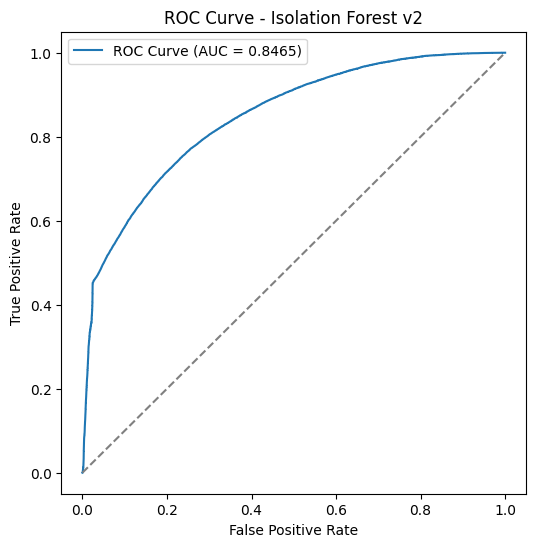

In [11]:
# ---- ROC Curve ----
fpr, tpr, thresholds = roc_curve(y_test_binary, y_scores)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Isolation Forest v2")
plt.legend()
plt.show()

In [12]:
# --- 6. Quick diagnostics for tuning ---
print("\nTotal test samples:", len(y_test_binary))
print("Total ground-truth attacks:", int(y_test_binary.sum()))
print("Total predicted attacks:", int(y_pred_binary.sum()))


Total test samples: 411883
Total ground-truth attacks: 19929
Total predicted attacks: 53878


In [13]:
# # ---- Convert Labels ----
# # Ground truth: 0 = normal, 1 = attack
# y_test_binary = np.where(y_test == 7, 0, 1)

# # --- 3. Raw anomaly scores ---
# y_scores = iso_model.decision_function(x_test)   # higher = normal, lower = anomaly

In [14]:
# # --- 4. Precision-Recall Curve + Threshold tuning ---
# precisions, recalls, thresholds = precision_recall_curve(y_test_binary, -y_scores)

# plt.figure(figsize=(7,5))
# plt.plot(recalls, precisions, linewidth=2)
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve - Isolation Forest")
# plt.grid()
# plt.show()

In [15]:
# # Choose threshold for target recall
# target_recall = 0.8
# idx = np.argmax(recalls >= target_recall)
# best_threshold = thresholds[idx]

# print(f"Best threshold for ~{target_recall:.2f} recall: {best_threshold:.4f}")

# # Apply tuned threshold
# y_pred_custom = np.where(-y_scores >= best_threshold, 1, 0)  # 1=attack, 0=normal

In [16]:
# print("Confusion Matrix:")
# print(confusion_matrix(y_test_binary, y_pred_custom))

In [17]:
# # --- 5. Evaluate ---
# print("\nClassification Report (with tuned threshold):")
# print(classification_report(y_test_binary, y_pred_custom, target_names=["normal","attack"]))

In [18]:
# # --- 6. ROC-AUC (optional) ---
# auc = roc_auc_score(y_test_binary, -y_scores)
# print(f"ROC-AUC: {auc:.4f}")

In [19]:
# # ---- Accuracy ----
# acc = accuracy_score(y_test_binary, y_pred_custom)
# print(f"\nAccuracy: {acc:.4f}")

In [20]:
# print("Train label distribution:")
# print(y_train.value_counts())

# print("\nTest label distribution:")
# print(y_test.value_counts())


In [21]:
# print("Train mean:", x_train_scaled.mean(), "std:", x_train_scaled.std())
# print("Test mean:", x_test_scaled.mean(), "std:", x_test_scaled.std())


In [22]:
# # ---- ROC Curve ----
# fpr, tpr, thresholds = roc_curve(y_test_binary, y_scores)
# plt.figure(figsize=(6,6))
# plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
# plt.plot([0,1], [0,1], linestyle="--", color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve - Isolation Forest v2")
# plt.legend()
# plt.show()

In [23]:
# # --- 6. Quick diagnostics for tuning ---
# print("\nTotal test samples:", len(y_test_binary))
# print("Total ground-truth attacks:", int(y_test_binary.sum()))
# print("Total predicted attacks:", int(y_pred_binary.sum()))

In [24]:
# print("Train distribution:\n", y_train.value_counts(normalize=True))
# print("Test distribution:\n", y_test.value_counts(normalize=True))
